## VI. Evaluation of the model

### A. Import libraries to use 

In [1]:
import numpy as np
import pandas as pd 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

### B. Load fitted model for prediction

In [2]:
from tensorflow import keras
model = keras.models.load_model('weights')

### C. Set parameters

In [3]:
FAST_RUN = False
IMAGE_WIDTH=64 #image pixel width
IMAGE_HEIGHT=64 #image pixel height
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 #image RGB channel
batch_size=15

### D. Prepare dataframe format from the training data

In [4]:
filenames = os.listdir("dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

#### Set class categories 

In [5]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

#### Prepare image generator

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "dogs-vs-cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### E. Prepare testing dataset

In [7]:
test_filenames = os.listdir("dogs-vs-cats/test2")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [8]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "dogs-vs-cats/test2", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 8000 validated image filenames.


### F. Predict the testing dataset

In [9]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [10]:
test_df['category'] = np.argmax(predict, axis=-1)

In [11]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [12]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

#### Save the results of the prediction

In [13]:
results_df = test_df.copy()
results_df['id'] = results_df['filename'].str.split('.').str[0]
results_df['label'] = results_df['category']
results_df.drop(['filename', 'category'], axis=1, inplace=True)
results_df.to_csv('results.csv', index=False)

#### Results from the prediction

In [14]:
# Load dataset
predictions_df = pd.read_csv('results.csv')

# Set true labels
predictions_df.loc[predictions_df['id'] == "cat", 'true'] = 0
predictions_df.loc[predictions_df['id'] == "dog", 'true'] = 1

# Show dataframe
predictions_df

,id,label,true
0,cat,0,0.0
1,cat,0,0.0
2,cat,0,0.0
3,cat,0,0.0
4,cat,0,0.0
...,...,...,...
7995,dog,1,1.0
7996,dog,1,1.0
7997,dog,1,1.0
7998,dog,0,1.0


In [15]:
# Count of accurate predictions for cats
true_cat_preds = predictions_df[(predictions_df["id"] == "cat") & (predictions_df["label"] == 0)].count()
print("Correct cat image predictions:", true_cat_preds[0])

# Count of inaccurate predictions for cats
false_cat_preds = predictions_df[(predictions_df["id"] == "cat") & (predictions_df["label"] == 1)].count()
print("Incorrect cat image predictions:", false_cat_preds[0])

# Count of accurate predictions for dogs
true_dog_preds = predictions_df[(predictions_df["id"] == "dog") & (predictions_df["label"] == 1)].count()
print("Correct dog image predictions:", true_dog_preds[0])

# Count of inaccurate predictions for dogs
false_dog_preds = predictions_df[(predictions_df["id"] == "dog") & (predictions_df["label"] == 0)].count()
print("Incorrect dog image predictions:", false_dog_preds[0])

# Total
print("Total image predictions:", true_cat_preds[0]+false_cat_preds[0]+true_dog_preds[0]+false_dog_preds[0])

Correct cat image predictions: 3541
Incorrect cat image predictions: 459
Correct dog image predictions: 3528
Incorrect dog image predictions: 472
Total image predictions: 8000


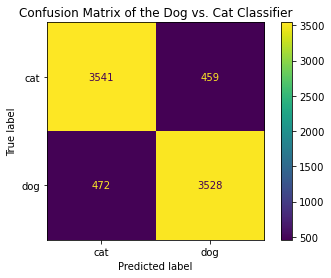

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get confusion matrix
cm = confusion_matrix(predictions_df["true"], predictions_df["label"])

# Show confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["cat", "dog"])
disp.plot()
plt.title('Confusion Matrix of the Dog vs. Cat Classifier')
plt.show()

#### Other metrics

In [17]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(predictions_df["true"], predictions_df["label"])
print("Accuracy of Classifier:", accuracy)
print()

# Precision, Recall, and F1-score
from sklearn.metrics import classification_report
print(classification_report(predictions_df["true"], predictions_df["label"], target_names=["cat", "dog"]))

Accuracy of Classifier: 0.883625

              precision    recall  f1-score   support

         cat       0.88      0.89      0.88      4000
         dog       0.88      0.88      0.88      4000

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



# End of notebook